# Notebook

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats
import seaborn as sns
from tabulate import tabulate

import lightgbm as lgb
from catboost import CatBoostRegressor

import matplotlib.pylab as plt
plt.style.use('ggplot')

In [4]:
train_apartment = pd.read_csv('../data/apartments_train.csv')
train_building = pd.read_csv('../data/buildings_train.csv')
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
#train.rename(columns={'id_x' : 'apartment_id', 'id_y' : 'building_id'}, inplace=True)
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)

In [23]:
test_apartment = pd.read_csv('../data/apartments_test.csv')
test_building = pd.read_csv('../data/buildings_test.csv')
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
#test.rename(columns={'id_x' : 'apartment_id', 'id_y' : 'building_id'}, inplace=True)
test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)

In [5]:
column_names_apartments = ['apartment_id', 'seller', 'area_total', 'area_kitchen', 'area_living',
       'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared',
       'bathrooms_private', 'windows_court', 'windows_street', 'balconies',
       'loggias', 'condition', 'phones', 'building_id', 'price']
column_names_buildings = ['new', 'latitude', 'longitude', 'district', 'street', 'address',
       'constructed', 'material', 'stories', 'elevator_without',
       'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute',
       'heating']
all_features = column_names_apartments[:-1] + column_names_buildings

In [6]:
def preprocess(data,price_outlier_rejection=False,fill=True):
    if price_outlier_rejection is True:
        data = data[(np.abs(stats.zscore(data['price'])) < 3.9)]
    if fill is True:
        return data.fillna(data.mean())
    else:
        return data.dropna()

In [7]:
train_apartment.describe()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id
count,23285.000000,14455.000000,2.328500e+04,23285.000000,18564.000000,19403.000000,23285.000000,23285.000000,5643.000000,12192.000000,19413.000000,19413.000000,15213.000000,15213.000000,12765.000000,12765.000000,13475.000000,23205.000000,23285.000000
mean,11642.000000,1.875683,2.355617e+07,74.450999,12.552279,38.741367,8.969594,2.189349,1.039695,3.268374,0.737547,0.662855,0.797147,0.468678,0.556365,0.673090,1.270501,1.162293,4844.089156
std,6721.944845,1.089518,5.264393e+07,58.671373,6.565686,31.398480,8.322039,1.076130,0.351507,10.802728,0.781173,0.716888,0.402137,0.499034,0.641257,0.664779,1.017037,0.456937,2790.676698
min,0.000000,0.000000,9.000000e+05,9.300000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5821.000000,1.000000,7.490000e+06,42.000000,8.200000,20.000000,3.000000,1.000000,1.000000,2.650000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2426.000000
50%,11642.000000,2.000000,1.064500e+07,59.800000,10.700000,30.900000,7.000000,2.000000,1.000000,2.800000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4772.000000
75%,17463.000000,3.000000,2.050000e+07,84.800000,15.300000,45.300000,12.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,7340.000000
max,23284.000000,3.000000,2.600000e+09,2181.000000,100.000000,900.000000,95.000000,6.000000,2.000000,340.000000,4.000000,4.000000,1.000000,1.000000,4.000000,4.000000,3.000000,2.000000,9735.000000


In [8]:
train_building.describe()

,id,new,latitude,longitude,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,6791.000000,6564.000000,6791.000000,6791.000000,6790.000000,6312.000000,5626.000000,6791.000000,6486.000000,6486.000000,6486.000000,2922.000000,4202.000000,5354.000000
mean,4860.179208,0.064442,55.727315,37.592880,4.507511,1985.772972,2.240135,12.958180,0.276750,0.830558,0.467777,0.764203,0.868634,0.083676
std,2809.331438,0.245558,0.106150,0.155806,2.948947,24.302534,1.325750,6.985574,0.447426,0.375171,0.498999,0.470468,0.337840,0.423597
min,0.000000,0.000000,55.211430,36.864371,0.000000,1855.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2445.500000,0.000000,55.656469,37.504874,2.000000,1968.000000,2.000000,9.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,4844.000000,0.000000,55.738799,37.591431,4.000000,1984.000000,3.000000,12.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,7300.500000,0.000000,55.803203,37.702445,6.000000,2007.000000,3.000000,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,9735.000000,1.000000,56.006507,37.950668,11.000000,2023.000000,6.000000,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


In [9]:
train_apartment_dropna = train_apartment.dropna()
train_apartment_dropna.describe()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id
count,1284.000000,1284.000000,1.284000e+03,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000
mean,12710.765576,1.075545,1.407531e+07,69.038917,10.110514,41.663442,7.707165,2.552960,1.014798,3.180857,0.397196,0.788162,0.916667,0.419003,0.499221,0.779595,1.298287,1.275701,4802.429128
std,6240.452480,0.772517,2.429002e+07,38.951808,4.701548,23.348758,5.223448,0.705948,0.360478,10.391965,0.681243,0.518091,0.276493,0.493588,0.595514,0.746321,0.779090,0.447041,2749.544531
min,77.000000,0.000000,3.900000e+06,33.000000,4.600000,2.100000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
25%,8188.750000,0.000000,8.496750e+06,51.975000,7.000000,30.400000,4.000000,2.000000,1.000000,2.640000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2468.750000
50%,12578.000000,1.000000,1.015000e+07,60.000000,9.200000,35.450000,7.000000,2.000000,1.000000,2.640000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4823.500000
75%,17929.500000,2.000000,1.350000e+07,76.000000,11.000000,45.500000,11.000000,3.000000,1.000000,2.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,7069.250000
max,23228.000000,2.000000,7.428684e+08,696.000000,47.000000,363.900000,38.000000,6.000000,2.000000,265.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,3.000000,2.000000,9717.000000


In [10]:
train_building_dropna = train_building.dropna()
train_building_dropna.describe()

,id,new,latitude,longitude,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000
mean,4802.589802,0.019830,55.730352,37.596609,4.504249,1988.508215,2.322380,14.621530,0.203966,0.953541,0.638527,0.844193,0.906516,0.103683
std,2794.690178,0.139455,0.101995,0.151256,2.810454,22.135292,1.201276,7.115232,0.403058,0.210536,0.480563,0.408354,0.291193,0.461700
min,1.000000,0.000000,55.412114,36.865647,0.000000,1860.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2453.000000,0.000000,55.656098,37.505903,2.000000,1972.000000,2.000000,9.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
50%,4745.000000,0.000000,55.733112,37.589015,5.000000,1992.000000,3.000000,14.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,7177.000000,0.000000,55.807238,37.703649,6.000000,2007.000000,3.000000,17.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,9728.000000,1.000000,56.006507,37.941568,11.000000,2022.000000,5.000000,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


In [11]:
train_apartement_fillna = train_apartment.fillna(train_apartment.mean())
train_apartement_fillna.describe()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id
count,23285.000000,23285.000000,2.328500e+04,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.00000,23285.000000,23285.000000,23285.000000
mean,11642.000000,1.875683,2.355617e+07,74.450999,12.552279,38.741367,8.969594,2.189349,1.039695,3.268374,0.737547,0.662855,0.797147,0.468678,0.556365,0.67309,1.270501,1.162293,4844.089156
std,6721.944845,0.858419,5.264393e+07,58.671373,5.862400,28.661774,8.322039,1.076130,0.173030,7.816715,0.713269,0.654573,0.325041,0.403362,0.474785,0.49220,0.773671,0.456152,2790.676698
min,0.000000,0.000000,9.000000e+05,9.300000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,5821.000000,1.000000,7.490000e+06,42.000000,9.000000,21.900000,3.000000,1.000000,1.039695,2.750000,0.000000,0.000000,0.797147,0.000000,0.000000,0.67309,1.000000,1.000000,2426.000000
50%,11642.000000,1.875683,1.064500e+07,59.800000,12.552279,35.000000,7.000000,2.000000,1.039695,3.268374,0.737547,0.662855,1.000000,0.468678,0.556365,0.67309,1.270501,1.000000,4772.000000
75%,17463.000000,3.000000,2.050000e+07,84.800000,13.900000,42.700000,12.000000,3.000000,1.039695,3.268374,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.270501,1.000000,7340.000000
max,23284.000000,3.000000,2.600000e+09,2181.000000,100.000000,900.000000,95.000000,6.000000,2.000000,340.000000,4.000000,4.000000,1.000000,1.000000,4.000000,4.00000,3.000000,2.000000,9735.000000


In [12]:
train_building_fillna = train_building.fillna(train_building.mean())
train_building_fillna.describe()

,id,new,latitude,longitude,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,6791.000000,6791.000000,6791.000000,6791.000000,6791.000000,6791.000000,6791.000000,6791.000000,6791.000000,6791.000000,6791.000000,6791.000000,6791.000000,6791.000000
mean,4860.179208,0.064442,55.727315,37.592880,4.507511,1985.772972,2.240135,12.958180,0.276750,0.830558,0.467777,0.764203,0.868634,0.083676
std,2809.331438,0.241419,0.106150,0.155806,2.948730,23.429648,1.206669,6.985574,0.437262,0.366648,0.487663,0.308575,0.265738,0.376112
min,0.000000,0.000000,55.211430,36.864371,0.000000,1855.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2445.500000,0.000000,55.656469,37.504874,2.000000,1969.000000,2.000000,9.000000,0.000000,1.000000,0.000000,0.764203,0.868634,0.000000
50%,4844.000000,0.000000,55.738799,37.591431,4.000000,1985.772972,2.240135,12.000000,0.000000,1.000000,0.000000,0.764203,1.000000,0.000000
75%,7300.500000,0.000000,55.803203,37.702445,6.000000,2006.000000,3.000000,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,9735.000000,1.000000,56.006507,37.950668,11.000000,2023.000000,6.000000,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


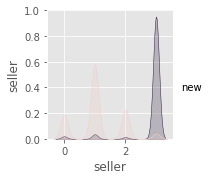

In [22]:
# print(tabulate(train[['new','seller']]))
sns.pairplot(train[['new','seller']], hue='new')

Conclusion: 
* if new = 1 then in most cases seller = 3
* if new = 0 then in most cases seller = 2

In [27]:
train.isna().sum()

apartment_id              0
seller                 8830
price                     0
area_total                0
area_kitchen           4721
area_living            3882
floor                     0
rooms                     0
layout                17642
ceiling               11093
bathrooms_shared       3872
bathrooms_private      3872
windows_court          8072
windows_street         8072
balconies             10520
loggias               10520
condition              9810
phones                   80
building_id               0
new                     264
latitude                  0
longitude                 0
district                130
street                    0
address                   0
constructed             794
material               3972
stories                   0
elevator_without        357
elevator_passenger      357
elevator_service        357
parking                6788
garbage_chute          8811
heating                8161
dtype: int64

In [26]:
test.isna().sum()

apartment_id             0
seller                3942
area_total               0
area_kitchen          2233
area_living           2019
floor                    0
rooms                    0
layout                7368
ceiling               5018
bathrooms_shared      1717
bathrooms_private     1717
windows_court         3488
windows_street        3488
balconies             4835
loggias               4835
condition             3959
phones                  40
building_id              0
new                    109
latitude                 2
longitude                2
district                25
street                   0
address                  0
constructed            374
material              1671
stories                  0
elevator_without       180
elevator_passenger     180
elevator_service       180
parking               2867
garbage_chute         3426
heating               3230
dtype: int64

Text(0.5, 1.0, 'Correlation all data')

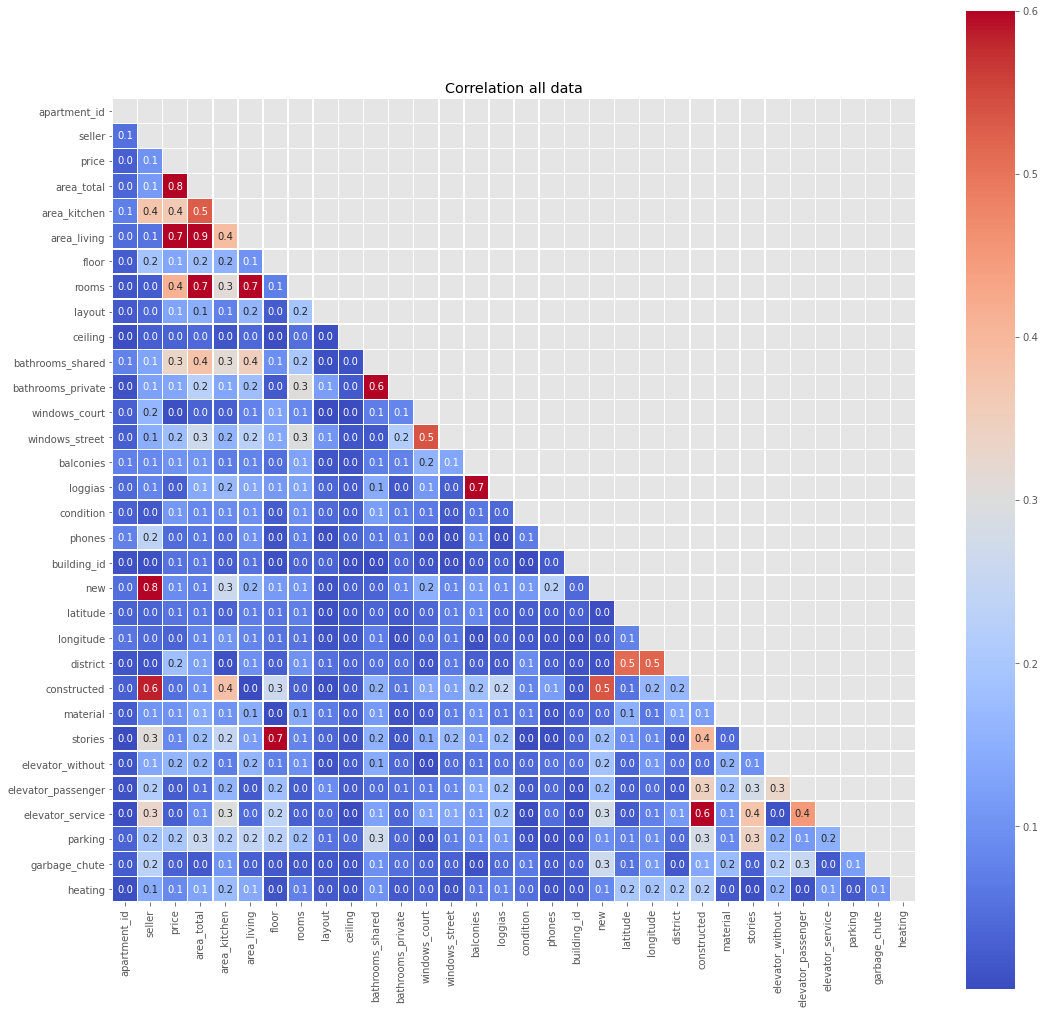

In [42]:
original_corr = train.corr()
mask = np.zeros_like(orriginal_corr)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(np.abs(train.corr()), mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation all data')
# plt.savefig("original_correlations.png")

Text(0.5, 1.0, 'Correlation drop NaN data')

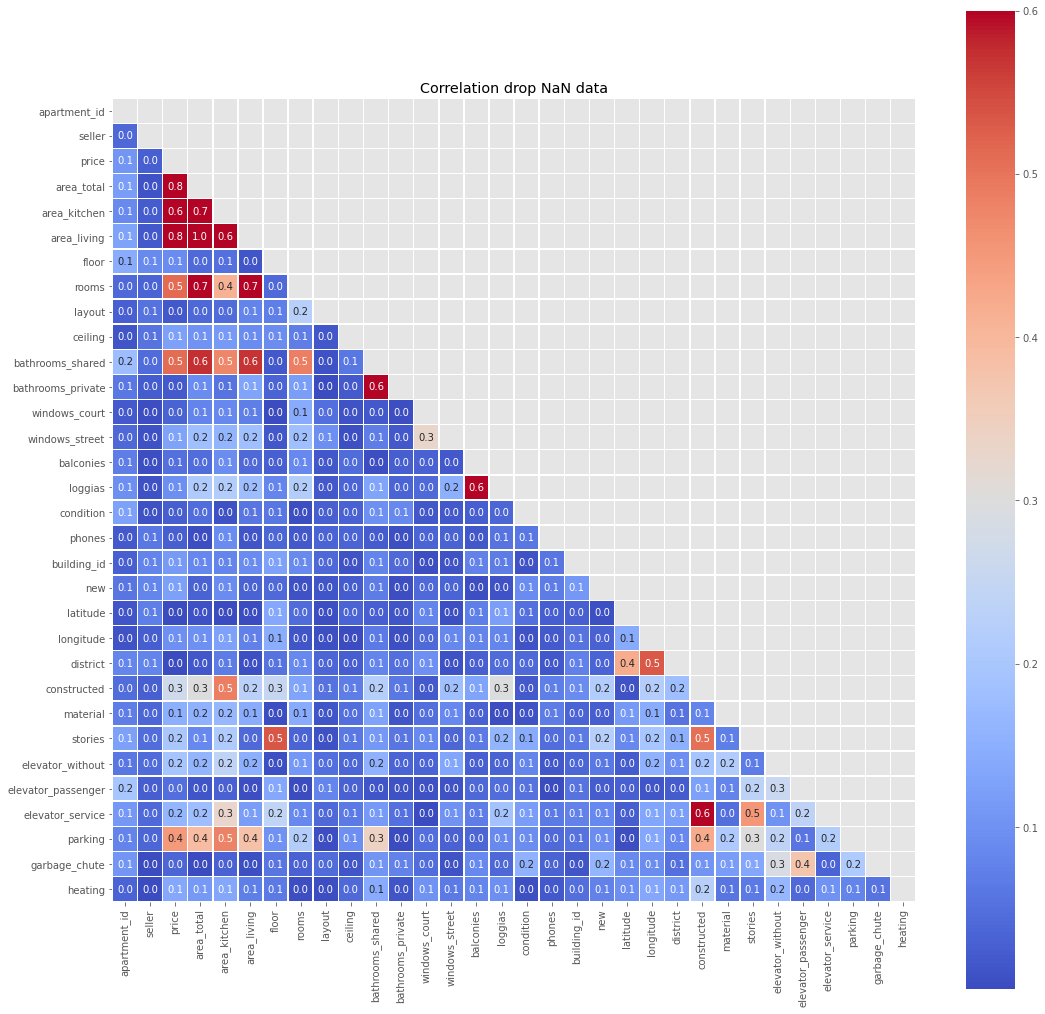

In [39]:
dropna_corr = train.dropna().corr()
mask = np.zeros_like(dropna_corr)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(np.abs(train.dropna().corr()), mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation drop NaN data')
# plt.savefig("dropped_na_correlations.png")

Text(0.5, 1.0, 'Correlation fill NaN data')

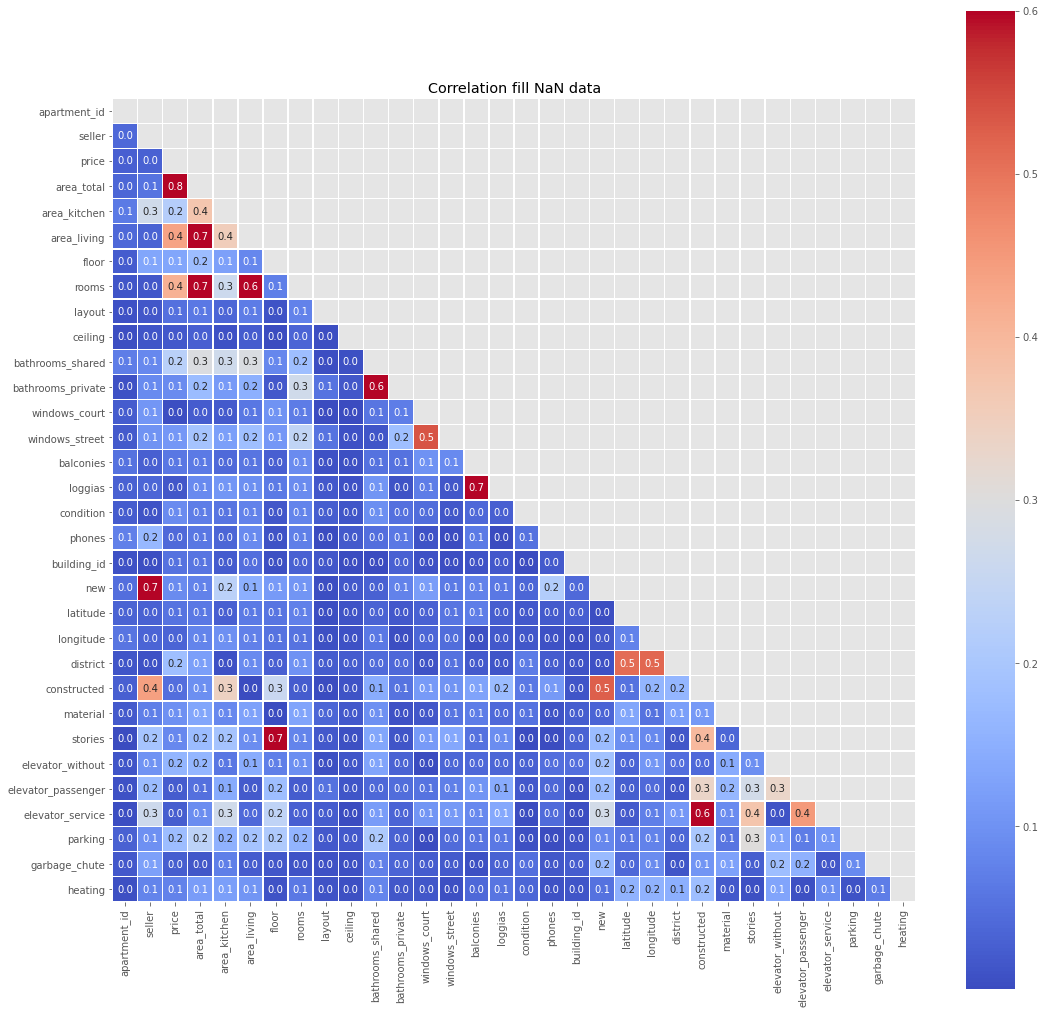

In [40]:
fillna_corr = train.fillna(train.mean()).corr()
mask = np.zeros_like(fillna_corr)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(np.abs(train.fillna(train.mean()).corr()), mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation fill NaN data with mean')
# plt.savefig("fill_na_correlations.png")

Text(0.5, 1.0, 'Correlation fill NaN data with median')

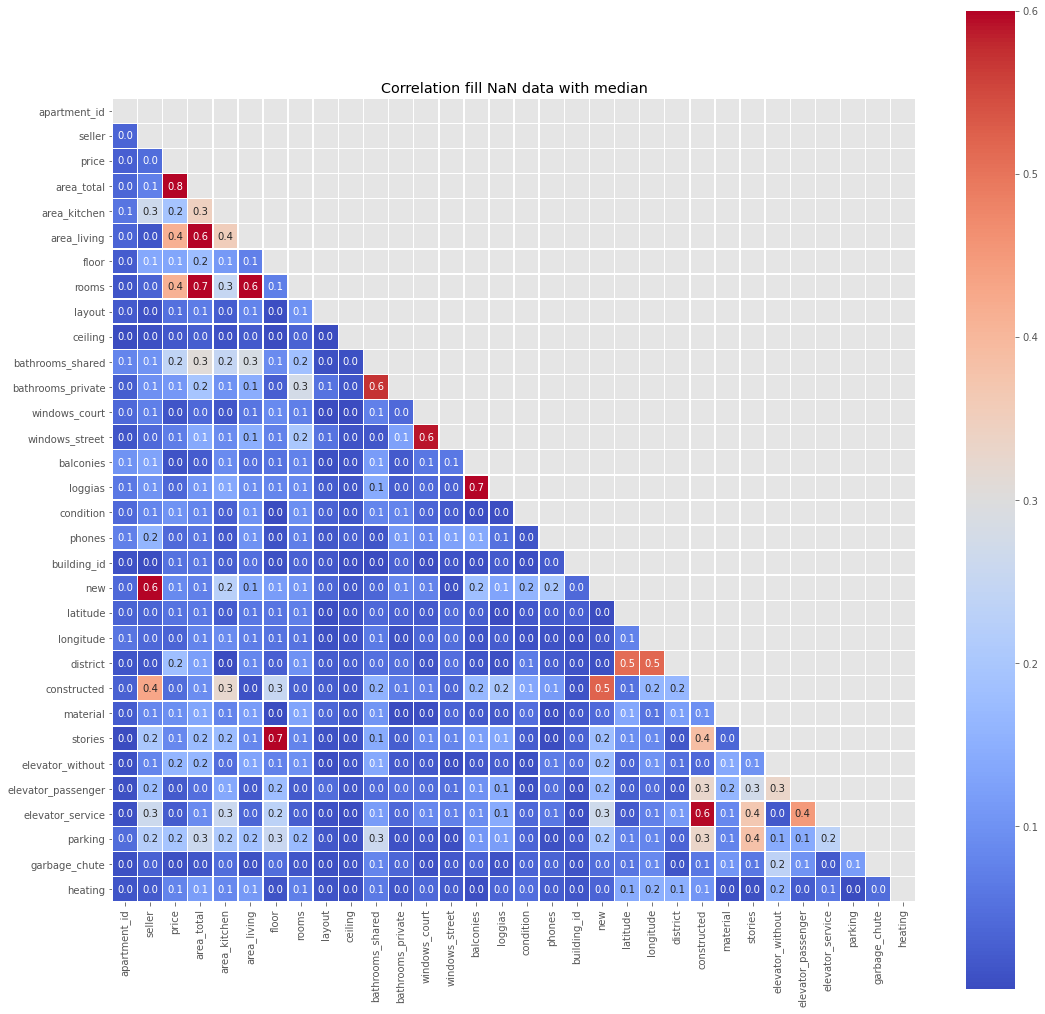

In [87]:
fillna_corr = train.fillna(train.median()).corr()
mask = np.zeros_like(fillna_corr)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(np.abs(fillna_corr), mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation fill NaN data with median')
# plt.savefig("fill_na_correlations_median.png")

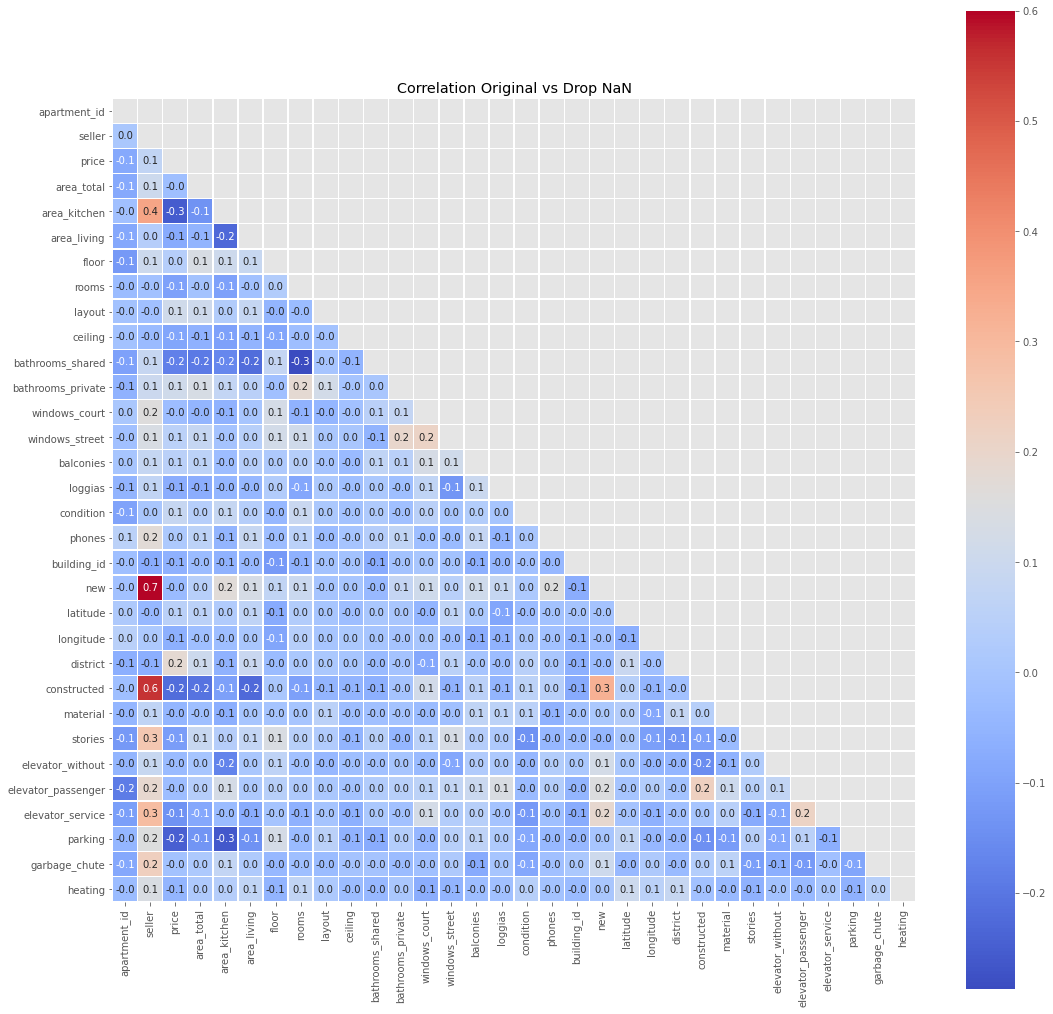

In [52]:
orig_drop = abs(original_corr) - abs(dropna_corr)
mask = np.zeros_like(orig_drop)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap((orig_drop), mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation Original vs Drop NaN')
plt.savefig("original_dropna.png")
# positive means that the original data performs better than the dropna data, negative means dropna performs better

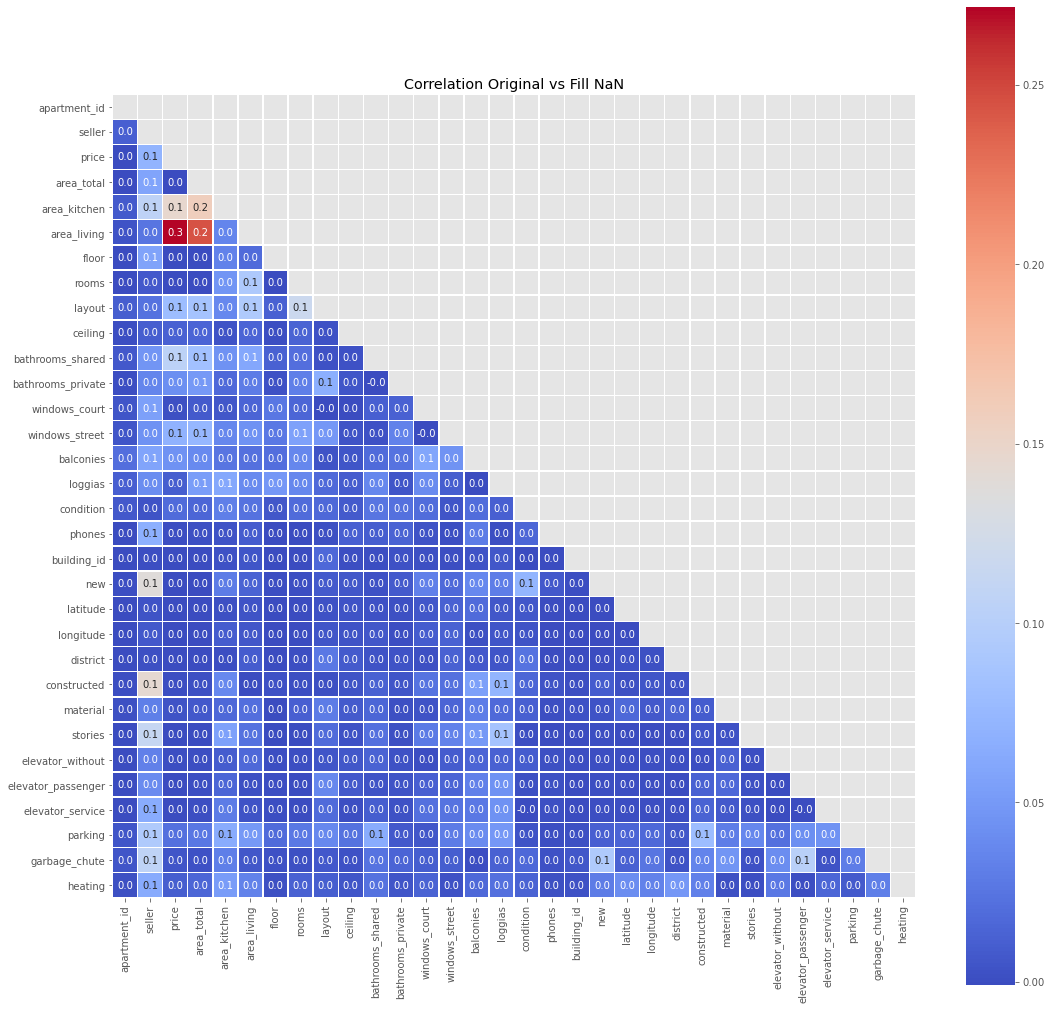

In [53]:
orig_fill = abs(original_corr) - abs(fillna_corr)
mask = np.zeros_like(orig_fill)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap((orig_fill), mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation Original vs Fill NaN')
plt.savefig("original_fillna.png")

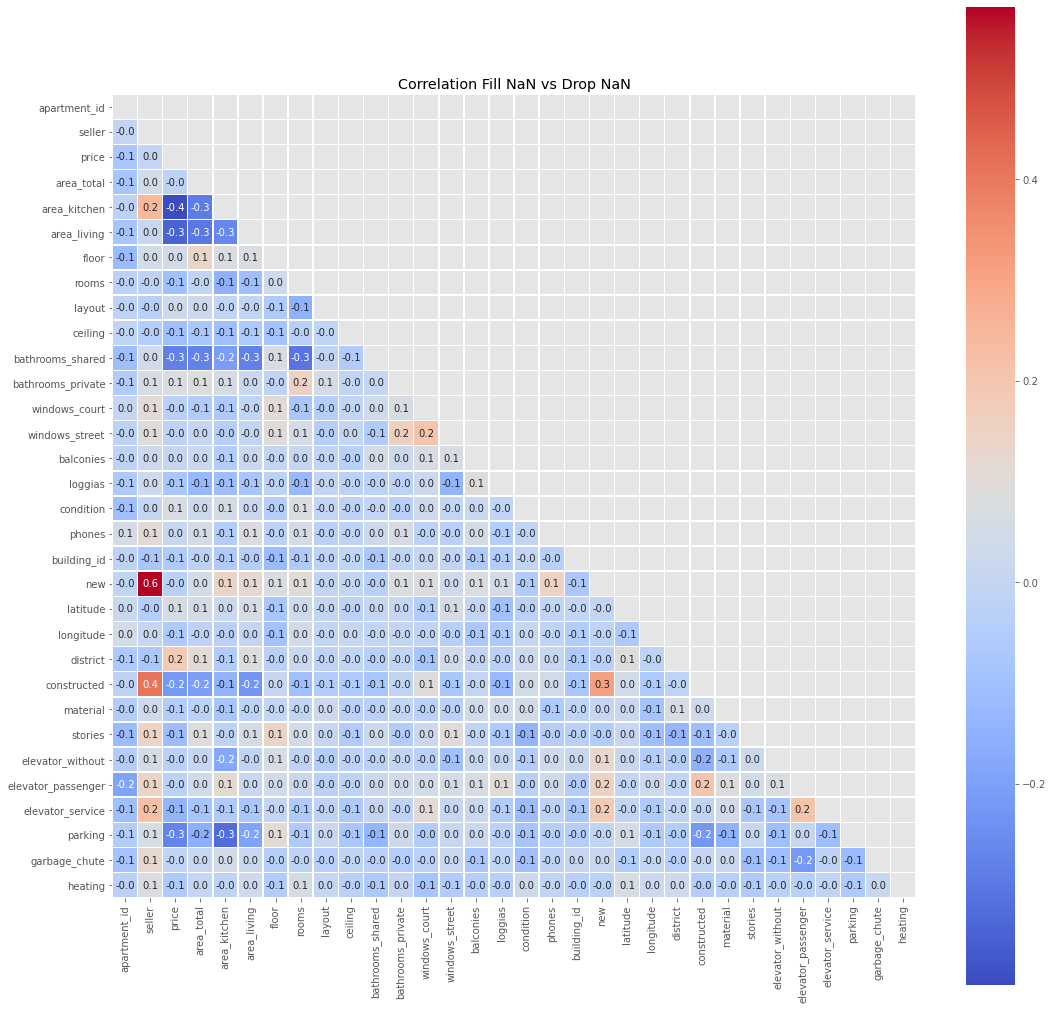

In [54]:
fill_drop = abs(fillna_corr) - abs(dropna_corr)
mask = np.zeros_like(fill_drop)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap((fill_drop), mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation Fill NaN vs Drop NaN')
plt.savefig("fillna_dropna.png")

In [59]:
train['new'].value_counts()

0.0    15247
1.0     7774
Name: new, dtype: int64

In [92]:
train_intermediate = train
train_intermediate['new'] = train_intermediate['new'].fillna(0.0)
train_intermediate.head()

,apartment_id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,12,3.0,4045140.0,19.8,5.2,9.6,17.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
2,55,3.0,9500240.0,79.7,17.0,41.5,9.0,3.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,104,3.0,4326660.0,23.4,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
4,106,3.0,4333980.0,23.8,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN


<function matplotlib.pyplot.show(close=None, block=None)>

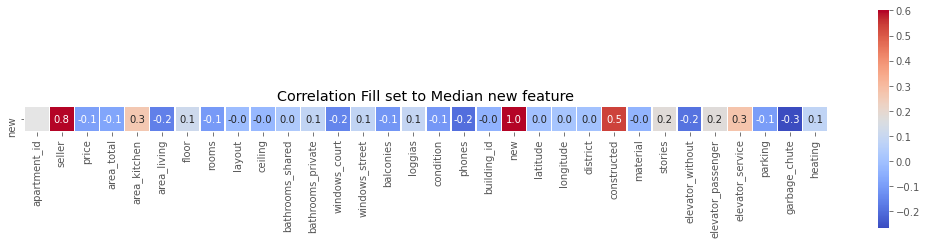

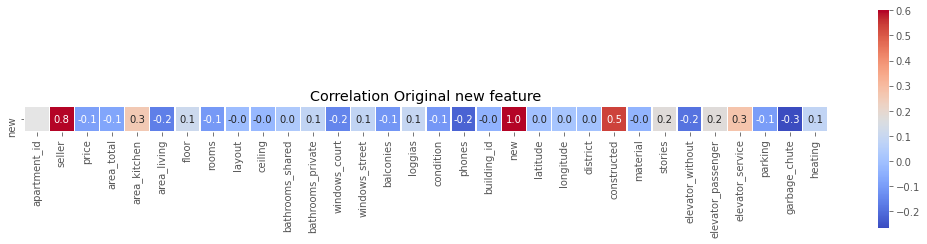

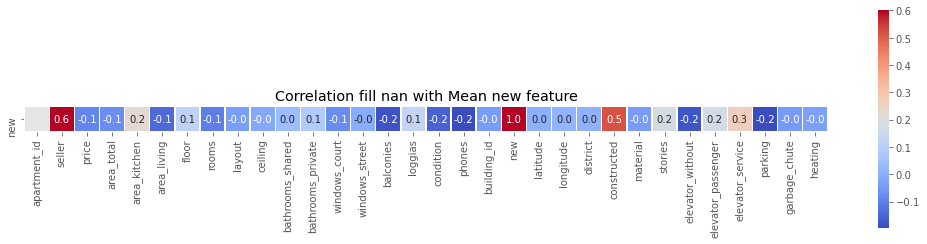

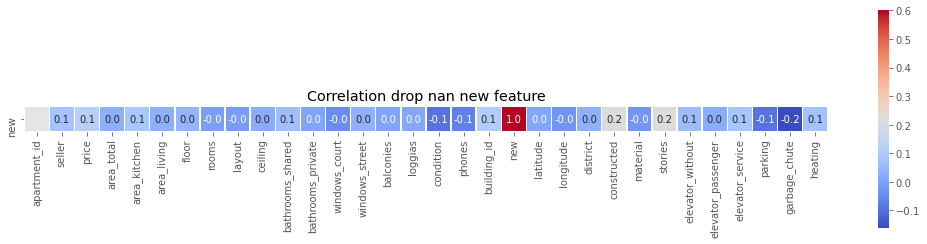

In [90]:
fill_new_median = train_intermediate.corr()[['new']]
mask = np.zeros_like(fill_new_median)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 4))
sns.heatmap((fill_new_median.T), mask=mask.T, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation Fill set to Median new feature')
plt.show

mask = np.zeros_like(original_corr[['new']])
mask[np.triu_indices_from(mask)] = True
f,ax = plt.subplots(figsize=(18, 4))
sns.heatmap((original_corr[['new']].T), mask=mask.T, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation Original new feature')
plt.show

mask = np.zeros_like(fillna_corr[['new']])
mask[np.triu_indices_from(mask)] = True
f,ax = plt.subplots(figsize=(18, 4))
sns.heatmap((fillna_corr[['new']].T), mask=mask.T, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation fill nan with Mean new feature')
plt.show

mask = np.zeros_like(dropna_corr[['new']])
mask[np.triu_indices_from(mask)] = True
f,ax = plt.subplots(figsize=(18, 4))
sns.heatmap((dropna_corr[['new']].T), mask=mask.T, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation drop nan new feature')
plt.show

In [95]:
train_intermediate['district'] = train_intermediate['district'].fillna(train_intermediate['district'].median())
train_intermediate.head()

,apartment_id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,12,3.0,4045140.0,19.8,5.2,9.6,17.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
2,55,3.0,9500240.0,79.7,17.0,41.5,9.0,3.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,104,3.0,4326660.0,23.4,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
4,106,3.0,4333980.0,23.8,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN


<function matplotlib.pyplot.show(close=None, block=None)>

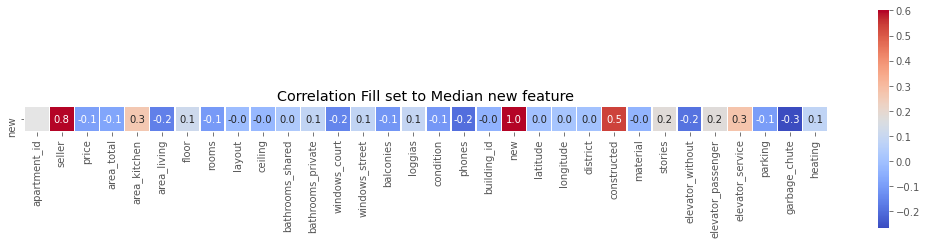

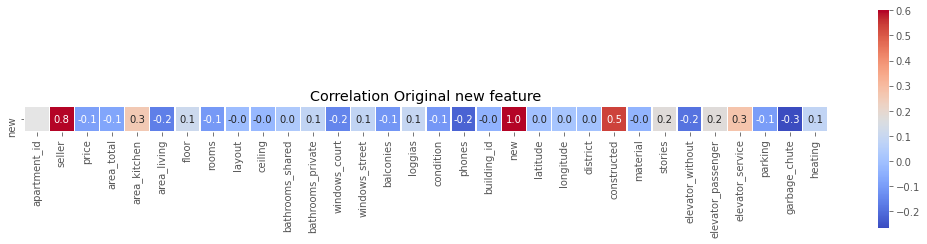

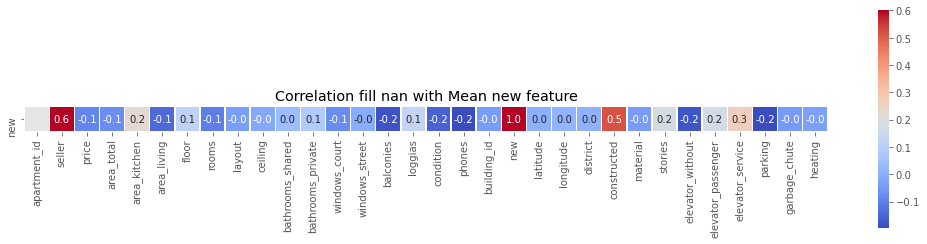

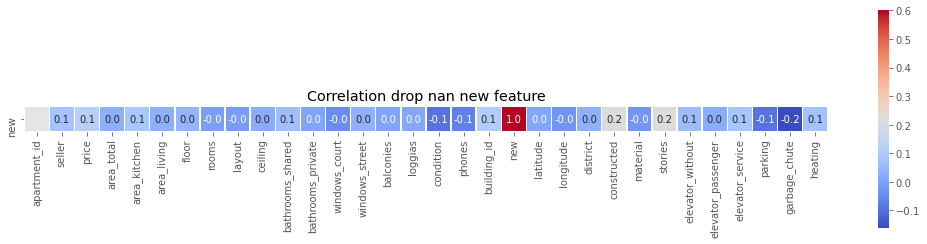

In [96]:
fill_new_median = train_intermediate.corr()[['new']]
mask = np.zeros_like(fill_new_median)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(18, 4))
sns.heatmap((fill_new_median.T), mask=mask.T, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation Fill set to Median district feature')
plt.show

mask = np.zeros_like(original_corr[['new']])
mask[np.triu_indices_from(mask)] = True
f,ax = plt.subplots(figsize=(18, 4))
sns.heatmap((original_corr[['new']].T), mask=mask.T, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation Original district feature')
plt.show

mask = np.zeros_like(fillna_corr[['new']])
mask[np.triu_indices_from(mask)] = True
f,ax = plt.subplots(figsize=(18, 4))
sns.heatmap((fillna_corr[['new']].T), mask=mask.T, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation fill nan with Mean district feature')
plt.show

mask = np.zeros_like(dropna_corr[['new']])
mask[np.triu_indices_from(mask)] = True
f,ax = plt.subplots(figsize=(18, 4))
sns.heatmap((dropna_corr[['new']].T), mask=mask.T, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation drop nan district feature')
plt.show